# 基于特征菌丰度的样本分类

In [248]:
import random
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
#from sklearn.metrics import plot_roc_curve

In [254]:
def model_eval(clf,train_data,train_label,test_data,test_label):
    # 获取训练集的准确率
    train_score = clf.score(train_data, train_label)
    print("训练集：", train_score)
    # 获取验证集的准确率
    test_score = clf.score(test_data, test_label)
    print("测试集：", test_score)
    #
    # 采用混淆矩阵（metrics）计算各种评价指标
    predicted=clf.predict(test_data)
    accuracy = metrics.precision_score(test_label, predicted, average='weighted')
    recall = metrics.recall_score(test_label, predicted, average='weighted')
    print('精准值：', accuracy)
    print('召回率：', recall)
    print('F1:', metrics.f1_score(test_label, predicted, average='weighted'))
    #print("准确率:", np.mean(test_label == predicted))

    #绘制ROC曲线
    # 计算ROC曲线的数据点
    # 计算FPR和TPR
    # fpr, tpr, thresholds = roc_curve(test_label, predicted)
    #
    # # 绘制ROC曲线
    # # 打印结果
    # print("False Positive Rate:", fpr)
    # print("True Positive Rate:", tpr)
    # print("Thresholds:", thresholds)
    # plt.plot(fpr, tpr, marker='o')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC Curve')
    #plt.show()
    #print(test_label)
    #print(predicted)
    probabilities = clf.predict_proba(test_data)
    probabilities_class0 = probabilities[:, 0]
    #print(probabilities_class0)
    # 创建分类器对象
    fpr, tpr, thresholds = roc_curve(test_label, probabilities_class0)
    print(fpr)
    print(tpr)
    print(thresholds)

    # # 使用线性插值方法生成平滑的ROC曲线
    interp_fpr = np.linspace(0, 1, 100)
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    print("interp_fpr ",interp_fpr)
    print("interp_tpr ",interp_tpr)
    # plt.plot(interp_fpr, interp_tpr, label='ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic (ROC) Curve')
    # plt.legend()
    # plt.show()


    # 计算AUC（Area Under Curve）
    roc_auc = auc(interp_fpr, interp_tpr)
    # 绘制ROC曲线
    plt.figure()
    plt.plot(interp_fpr, interp_tpr, color='darkorange', lw=2, label=f' (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.text(0.6, 0.2, f'Accuracy: {accuracy:.2f}\nRecall: {recall:.2f}', fontsize=12)
    plt.show()


def visualize_cv(cv, X, y):
    fig, ax = plt.subplots(figsize=(10, 5))

    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        p1 = ax.scatter(tr, [ii] * len(tr), c="#221f1f", marker="_", lw=8)
        p2 = ax.scatter(tt, [ii] * len(tt), c="#b20710", marker="_", lw=8)
        ax.set(
            title=cv.__class__.__name__,
            xlabel="Data Index",
            ylabel="CV Iteration",
            ylim=[cv.n_splits, -1],
        )
        ax.legend([p1, p2], ["Training", "Validation"])
    plt.show()

def plot_roc_curve(fpr,tpr,accuracy,recall,F1,title):
    # 计算AUC（Area Under Curve）
    roc_auc = auc(fpr, tpr)
    # 绘制ROC曲线
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{title} (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.text(0.6, 0.2, f'Accuracy: {accuracy:.2f}\nRecall: {recall:.2f}\nF1: {F1:.2f}', fontsize=12)
    plt.savefig(f'./results/{title}.jpg',bbox_inches='tight',dpi=300)
    plt.show()


def plot_pr_curve(precisions,recalls,title):
    # 计算AUC（Area Under Curve）
    #roc_auc = auc(fpr, tpr)
    # 绘制ROC曲线
    plt.figure()
    plt.plot(precisions, recalls, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    #plt.text(0.6, 0.2, f'Accuracy: {accuracy:.2f}\nRecall: {recall:.2f}\nF1: {F1:.2f}', fontsize=12)
    #plt.savefig(f'./results/{title}.jpg',bbox_inches='tight',dpi=300)
    plt.show()




In [256]:
#随机交叉验证数据导入
def load_data(cols,data,train_data,train_label,train_sample,test_data,test_label,test_sample):
    random.shuffle(cols)
    for col in cols:
        if cols.index(col) <= int(len(cols)*0.6):
            train_data.append(list(data.loc[:,col]))
            train_sample.append(col)
            if col.split('_')[0][-1] == 'N':
                train_label.append(0)
            else:
                train_label.append(1)
        else:
            test_data.append(list(data.loc[:,col]))
            test_sample.append(col)
            if col.split('_')[0][-1] == 'N':
                test_label.append(0)
            else:
                test_label.append(1)
#随机交叉验证
def Random_Cross_Validation(n_cols,t_cols,data):
    t_copy_cols = copy.deepcopy(t_cols)
    random.shuffle(t_copy_cols)
    t_copy_cols = t_copy_cols[:len(n_cols)]
    #print(columns)
    clf = SVC(probability=True)
    accuracies = []
    recalls = []
    F1s = []
    for i in range(10):
        print(i)
        train_data = []
        train_label = []
        train_sample = []
        test_data = []
        test_label = []
        test_sample = []
        load_data(n_cols,data,train_data,train_label,train_sample,test_data,test_label,test_sample)
        load_data(t_copy_cols,data,train_data,train_label,train_sample,test_data,test_label,test_sample)
        clf.fit(train_data,train_label)
        predicted=clf.predict(test_data)
        accuracy = metrics.precision_score(test_label, predicted, average='weighted')
        recall = metrics.recall_score(test_label, predicted, average='weighted')
        F1 = metrics.f1_score(test_label, predicted, average='weighted')
        print('精准值：', accuracy)
        print('召回率：', recall)
        print('F1:', F1)
        accuracies.append(accuracy)
        recalls.append(recall)
        F1s.append(F1)
    print("均值")
    print(np.mean(accuracies))
    print(np.mean(recalls))
    print(np.mean(F1s))

def roc_plot(label,probabilities,accuracy,recall,title):

    fpr, tpr, thresholds = roc_curve(label, probabilities)
    # # 使用线性插值方法生成平滑的ROC曲线
    interp_fpr = np.linspace(0, 1, 100)
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    fpr = interp_fpr
    tpr = interp_tpr
    # 计算AUC（Area Under Curve）
    roc_auc = auc(fpr, tpr)
    # 绘制ROC曲线
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    # plt.legend(loc="lower right")
    # plt.text(0.6, 0.2, f'Accuracy: {accuracy:.2f}\nRecall: {recall:.2f}', fontsize=12)
    # plt.savefig(f'./results/{title}.jpg',bbox_inches='tight',dpi=300)
    plt.show()

def get_fpr_tpr(label,probabilities):
    fpr, tpr, thresholds = roc_curve(label, probabilities)
    # # 使用线性插值方法生成平滑的ROC曲线
    interp_fpr = np.linspace(0, 1, 100)
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    fpr = interp_fpr
    tpr = interp_tpr
    return fpr,tpr

#留一交叉验证
def LOOCV(n_cols,t_cols,data,clf,sample_type):
    t_copy_cols = copy.deepcopy(t_cols)
    #random.shuffle(t_copy_cols)
    #t_copy_cols = t_copy_cols[:]
    cols = n_cols + t_copy_cols
    lenth = len(cols)
    predicted = []
    label = []
    probs = []
    for i in range(lenth):
        copy_cols = copy.deepcopy(cols)
        copy_cols.pop(i)
        train_data = []
        train_label = []
        train_sample = []
        for col in copy_cols:
            train_data.append(list(data.loc[:,col]))
            train_sample.append(col)
            if col.split('_')[0][-1] == 'N':
                train_label.append(0)
            else:
                train_label.append(1)
        test_data = [list(data.loc[:,cols[i]])]
        if cols[i].split('_')[0][-1] == 'N':
            label.append(0)
        else:
            label.append(1)
        if sample_type == "under":
            rus = RandomUnderSampler(random_state=42)
            #下采样
            train_data, train_label = rus.fit_resample(train_data, train_label)
        elif sample_type == "over":
            ros = RandomOverSampler(random_state=42)
            #上采样
            train_data, train_label = ros.fit_resample(train_data, train_label)


        clf.fit(train_data,train_label)

        predicted.append(clf.predict(test_data)[0])
        probs.append(clf.predict_proba(test_data)[0][1])
        #break
    # print(label)
    # print(predicted)
    accuracy = metrics.precision_score(label, predicted, average='weighted')
    recall = metrics.recall_score(label, predicted, average='weighted')
    F1 = metrics.f1_score(label, predicted, average='weighted')
    # print('精准值：', accuracy)
    # print('召回率：', recall)
    # print('F1:', F1)
    #roc_plot(label,probs,accuracy,recall,f"class_weight={weights},kernel={kernel}")
    fpr,tpr = get_fpr_tpr(label,probs)
    precisions, recalls, thresholds = precision_recall_curve(label, probs)
    return fpr,tpr,accuracy,recall,F1

#Random_Cross_Validation(n_cols,t_cols,data)



In [109]:
#处理输入数据
N_data = pd.read_csv("./data/N.txt",sep="\t")
T_data = pd.read_csv("./data/T.txt",sep="\t")
data = N_data.merge(T_data)
#print(data)
#columns = data.columns.tolist()[1:]
n_cols = N_data.columns.tolist()[1:]
t_cols = T_data.columns.tolist()[1:]
print(t_cols)

['P1492T_rna', 'P156T_rna', 'P160T_rna', 'P180T_rna', 'P193T_rna', 'P198T_rna', 'P207T_rna', 'P223T_rna', 'P229T_rna', 'P268T_rna', 'P270T_rna', 'P303T_rna', 'P311T_rna', 'P326T_rna', 'P367T_rna', 'P368T_rna', 'P394T_rna', 'L001T_rna', 'L002T_rna', 'L003T_rna', 'L004T_rna', 'L005T_rna', 'L006T_rna', 'L007T_rna', 'L008T_rna', 'L009T_rna', 'L010T_rna', 'L011T_rna', 'L012T_rna', 'L013T_rna', 'L014T_rna', 'L015T_rna', 'L016T_rna', 'L017T_rna', 'L018T_rna', 'L019T_rna', 'L020T_rna', 'L021T_rna', 'L022T_rna', 'L023T_rna', 'L024T_rna', 'L025T_rna', 'L026T_rna', 'L027T_rna', 'L028T_rna', 'L029T_rna', 'L030T_rna', 'L031T_rna', 'L032T_rna', 'L033T_rna', 'L034T_rna', 'L035T_rna', 'L036T_rna', 'L037T_rna', 'L038T_rna', 'L039T_rna', 'L040T_rna', 'L041T_rna', 'L042T_rna', 'L043T_rna', 'L044T_rna', 'L045T_rna', 'L046T_rna', 'L047T_rna', 'L048T_rna', 'L049T_rna', 'L050T_rna', 'L051T_rna', 'L052T_rna', 'L053T_rna', 'L054T_rna', 'L055T_rna', 'L056T_rna', 'L057T_rna', 'L058T_rna', 'L059T_rna', 'L060T_rna

# Svm

In [140]:
#svm
# weights_list = [[5,1],[5,2],[5,3],[5,4],[5,5],[4,5],[3,5],[2,5],[1,5]]
# kernel_list = ['linear' for i in range(9)]
weights_list = [[5,2],[5,2],[5,2],[5,2]]
kernel_list = ['linear','poly','rbf','sigmoid']
colors = ['#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#00FFFF', '#0000FF', '#800080', '#FF00FF', '#008000']
#darkorange
fprs = []
tprs = []
aucs = []
for i in range(len(weights_list)):
    weights = weights_list[i]
    kernel = kernel_list[i]
    clf_svm = SVC(probability=True,class_weight={0: weights[0], 1: weights[1]},kernel=kernel)
    fpr ,tpr = LOOCV(n_cols,t_cols,data,clf_svm,"normal")
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))

# 绘制ROC曲线

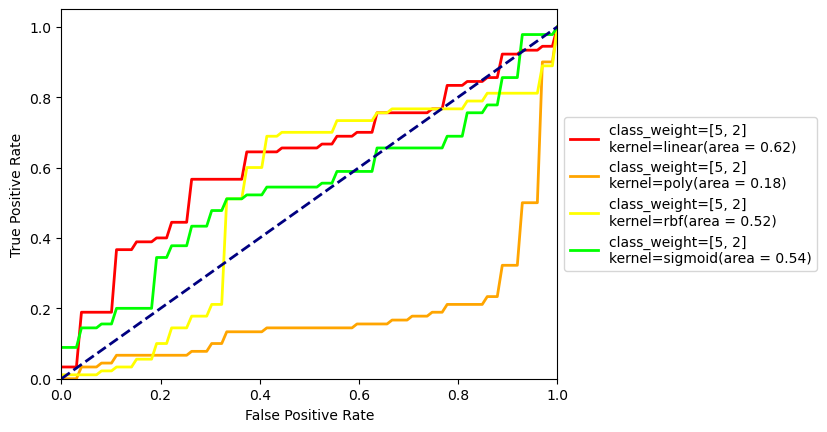

In [141]:
plt.figure()
for i in range(len(weights_list)):
    plt.plot(fprs[i], tprs[i], color=colors[i], lw=2, label=f"class_weight={weights_list[i]}\nkernel={kernel_list[i]}(area = %0.2f)"% aucs[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title = 'fig2'
plt.savefig(f'./results/{title}.jpg',bbox_inches='tight',dpi=300)
plt.show()

# 随机森林

In [152]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [226]:
clf_forest = RandomForestClassifier(n_estimators=100, random_state=42)

In [258]:
fprs = []
tprs = []
labels = []

In [259]:
fpr ,tpr,accuracy,recall,F1= LOOCV(n_cols,t_cols,data,clf_forest,"normal")
fprs.append(fpr)
tprs.append(tpr)
labels.append(f"Imbalanced dataset \naccuracy={round(accuracy,2)}\nrecall={round(recall,2)}\nF1={round(F1,2)}")

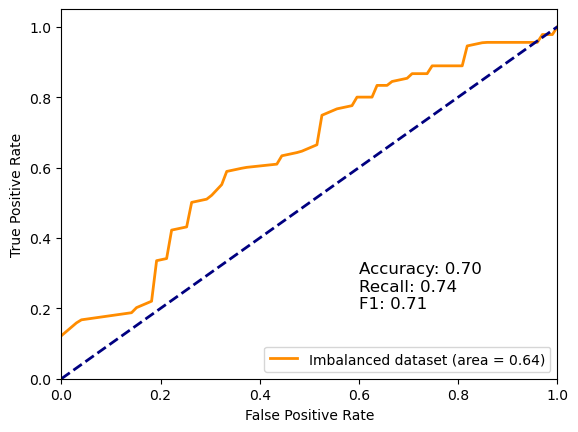

In [260]:
plot_roc_curve(fpr,tpr,accuracy,recall,F1,"Imbalanced dataset")
#plot_pr_curve(precisions,recalls,"test")

## 欠采样

In [261]:
fpr ,tpr,accuracy,recall,F1 = LOOCV(n_cols,t_cols,data,clf_forest,"under")
fprs.append(fpr)
tprs.append(tpr)
labels.append(f"Undersampling dataset \naccuracy={round(accuracy,2)}\nrecall={round(recall,2)}\nF1={round(F1,2)}")

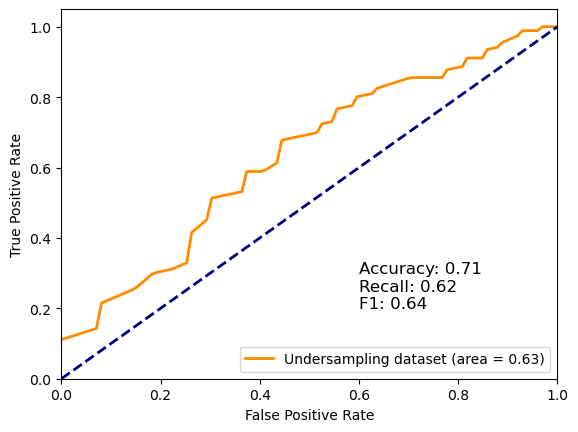

In [262]:
plot_roc_curve(fpr,tpr,accuracy,recall,F1,"Undersampling dataset")

## 过采样

In [263]:
fpr ,tpr,accuracy,recall,F1 = LOOCV(n_cols,t_cols,data,clf_forest,"over")
fprs.append(fpr)
tprs.append(tpr)
labels.append(f"Oversampling dataset \naccuracy={round(accuracy,2)}\nrecall={round(recall,2)}\nF1={round(F1,2)}")

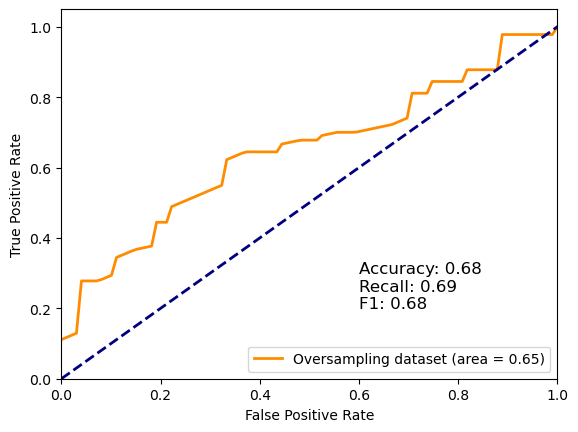

In [264]:
plot_roc_curve(fpr,tpr,accuracy,recall,F1,"Oversampling dataset")

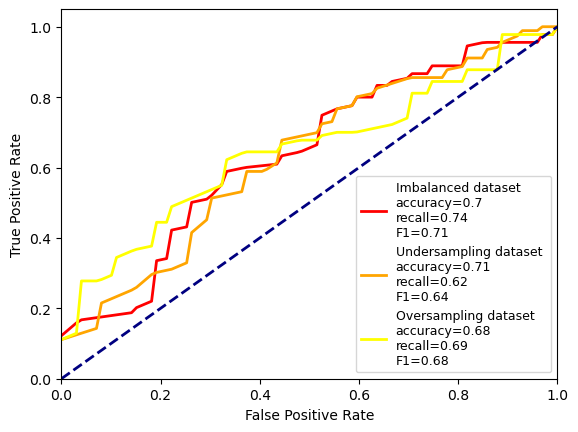

In [265]:
plt.figure()
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], color=colors[i], lw=2, label=labels[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right",fontsize=9)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title = 'fig3'
plt.savefig(f'./results/{title}.jpg',bbox_inches='tight',dpi=300)
plt.show()